In [1]:
coco_classes = ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

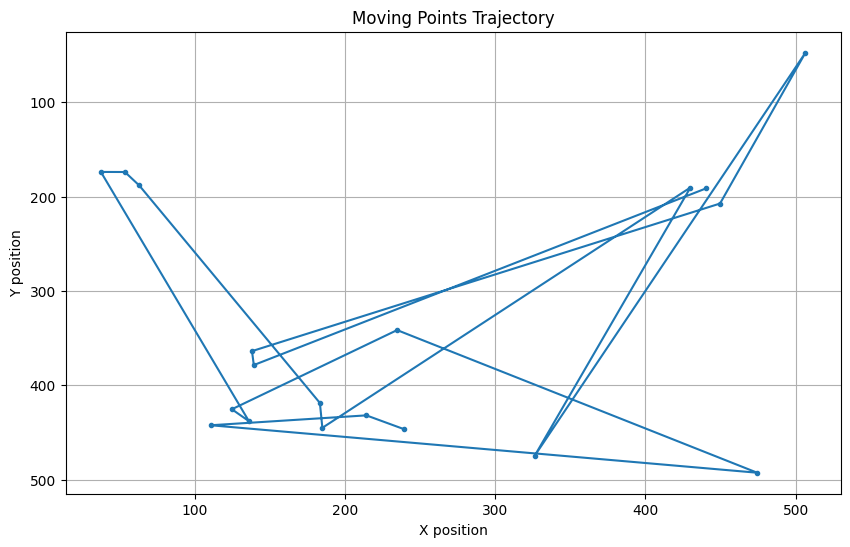

In [2]:

dynamic_classes = {"person", "car", "bicycle", "dog", "cat", "ball", "motorbike", "truck", "bus"}
static_classes = {"chair", "table", "bench", "bed", "refrigerator", "pottedplant", "toilet", "sofa"}

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define parameters for goodFeaturesToTrack
feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)

# Initialize YOLO model
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")  # Make sure these paths are correct
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Open the video

moving_points_over_time = []  # Track moving optical flow points  # To track object positions per frame

heatmap = np.zeros((480, 640), dtype=np.float32)  # adjust to your video resolution
cap = cv2.VideoCapture("room.mp4")

# Initialize the previous frame and points for optical flow
prev_gray = None
prev_points = None

# Loop through the video frames
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect objects using YOLO
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # Get the bounding boxes of detected objects
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:  # Minimum confidence threshold
                center_x = int(detection[0] * frame.shape[1])
                center_y = int(detection[1] * frame.shape[0])
                w = int(detection[2] * frame.shape[1])
                h = int(detection[3] * frame.shape[0])
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                moving_points_over_time.extend([(a, b) for (a, b) in moved_points])

                label = coco_classes[class_id]
                color = (0, 255, 255)  # Cyan
                cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
                
                # Check for unexpected motion (semantic + tracking)
                motion_score = sum(
                    1 for (px, py) in moved_points
                    if x <= px <= x + w and y <= py <= y + h
                )
                if label in static_classes and motion_score > 1:
                    print(f"Unexpected motion detected in '{label}' at ({x}, {y}) with score: {motion_score}")

                cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        

    # If previous points exist, calculate optical flow
    if prev_points is not None:
        # Calculate optical flow
        next_points, status, _ = cv2.calcOpticalFlowPyrLK(prev_gray, gray, prev_points, None)

        # Ensure status array matches points
        valid_points = next_points[status == 1]
        prev_valid_points = prev_points[status == 1]

        
        
        moved_points = []  # Ensure moved_points is defined
        # Update heatmap with moving points
        for (a, b), (c, d) in zip(moved_points, prev_valid_points):
            x, y = int(b), int(a)
            if 0 <= x < heatmap.shape[0] and 0 <= y < heatmap.shape[1]:
                movement = np.sqrt((a - c)**2 + (b - d)**2)
                heatmap[x, y] += movement
                heatmap[x, y] += 1
            
        # Visualize tracked points
        moved_points = []
        for i, (new, old) in enumerate(zip(valid_points, prev_valid_points)):
            a, b = new.ravel()
            c, d = old.ravel()
            movement = np.sqrt((a - c)**2 + (b - d)**2)
            if movement > 2:  # Threshold to consider the point as "moving"
                moved_points.append((a, b))
                frame = cv2.circle(frame, (int(a), int(b)), 5, (0, 0, 255), -1)  # Red dot for moving points
            #else:
                #frame = cv2.circle(frame, (int(a), int(b)), 3, (255, 0, 0), -1)  # Blue dot for stationary points
        
        # Draw lines between matching points
        for i, (new, old) in enumerate(zip(valid_points, prev_valid_points)):
            a, b = new.ravel().astype(int)  # Ensure points are integers
            c, d = old.ravel().astype(int)  # Ensure points are integers
            frame = cv2.line(frame, (a, b), (c, d), (0, 255, 0), 2)

        # Now, calculate homography if enough points are valid
        if len(valid_points) >= 4:  # At least 4 points are needed for homography
            H, _ = cv2.findHomography(prev_valid_points, valid_points, cv2.RANSAC)
            # Optionally, you can warp the frame with the homography matrix
            height, width = frame.shape[:2]
            warped_frame = cv2.warpPerspective(frame, H, (width, height))

    # Detect new feature points
    prev_points = cv2.goodFeaturesToTrack(gray, mask=None, **feature_params)

    # Show the frame with detected optical flow
    last_valid_frame = frame.copy()
    cv2.imshow('Frame', frame)

    # Press 'q' to quit the video display window
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    # Update previous frame
    prev_gray = gray

# Release resources and close windows
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    cv2.imshow("Video", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to quit
        break

cap.release()
cv2.destroyAllWindows()

# Plot object movement trajectory
import matplotlib.pyplot as plt
if moving_points_over_time:
    xs, ys = zip(*moving_points_over_time)
    plt.figure(figsize=(10, 6))
    plt.plot(xs, ys, marker='o', linestyle='-', markersize=3)
    plt.title('Moving Points Trajectory')
    plt.xlabel('X position')
    plt.ylabel('Y position')
    plt.grid(True)
    plt.gca().invert_yaxis()  # Y-axis inverted to match image coordinates
    plt.show()



# Normalize and blur heatmap
heatmap_blurred = cv2.GaussianBlur(heatmap, (25, 25), 0)
heatmap_norm = cv2.normalize(heatmap_blurred, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
heatmap_color = cv2.applyColorMap(heatmap_norm, cv2.COLORMAP_JET)

# Resize heatmap to match frame dimensions
heatmap_color = cv2.resize(heatmap_color, (last_valid_frame.shape[1], last_valid_frame.shape[0]))

# Overlay heatmap on original frame
overlay = cv2.addWeighted(last_valid_frame, 0.6, heatmap_color, 0.4, 0)


# Overlay heatmap on original frame
overlay = cv2.addWeighted(last_valid_frame, 0.6, heatmap_color, 0.4, 0)
cv2.imshow("Overlayed Heatmap", overlay)
cv2.waitKey(0)
cv2.destroyAllWindows()
